<a href="https://colab.research.google.com/github/yoshi-karino/my_kaggle/blob/main/230529_Kaggle_NYTaxi_mane2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/sridharstreaks/new-york-taxi-fare-prediction-score-3-1899/notebook
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 120) #to remove the limit of columns shows as output

# Importing Necessary libraies for viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# This is just some asthetics settings for plots before we start EDA
pd.set_option('display.max_columns', None) #Enable to show max columns in code cells
sns.set_style('darkgrid') #set sns plot background
matplotlib.rcParams['font.size'] = 14 #set the deafult plot font size for this notebook
matplotlib.rcParams['figure.figsize'] = (10, 6) #set the deafult plot size for this notebook
matplotlib.rcParams['figure.facecolor'] = '#00000000' #set matplotlib plot background

In [8]:
#sample_size=0.1 #i'm taking a sample size of 10%
sample_size=1 #i'm taking a sample size of 100%

import random
random.seed(123)

dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
}

train = pd.read_csv(
         "./train_5per.csv",
         skiprows=lambda i: i>0 and random.random() > sample_size,dtype=dtypes
)
#This function is simple and effective to apply.
# you can find this code here (https://stackoverflow.com/a/48589768)
print("before dropping NA:{}".format(train.isna().sum()))
train=train.dropna()            # Dropping NA
print("before dropping NA:{}".format(train.isna().sum()))
train.shape

before dropping NA:Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     1
pickup_latitude      1
dropoff_longitude    2
dropoff_latitude     2
passenger_count      1
dtype: int64
before dropping NA:Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


(519838, 9)

In [9]:
test=pd.read_csv("./test.csv")
print("before dropping NA:{}".format(train.isna().sum()))
test=test.dropna()                                    # Dropping NA
print("before dropping NA:{}".format(train.isna().sum()))
test.describe()

before dropping NA:Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
before dropping NA:Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [11]:
def remove_outliers(df):
    return df[(df['fare_amount'] >=1.) &
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) &
              (df['pickup_longitude'] <= -72) &
              (df['dropoff_longitude'] >= -75) &
              (df['dropoff_longitude'] <= -72) &
              (df['pickup_latitude'] >= 40) &
              (df['pickup_latitude'] <= 42) &
              (df['dropoff_latitude'] >=40) &
              (df['dropoff_latitude'] <= 42) &
              (df['passenger_count'] >= 1) &
              (df['passenger_count'] <= 6)]

In [12]:
# This function return distance calcuated from 4 points
def haversine_np(lon1, lat1, lon2, lat2):

    """Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length."""

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [13]:
train['trip_distance'] = haversine_np(train['pickup_longitude'], train['pickup_latitude'], train['dropoff_longitude'], train['dropoff_latitude'])
train = remove_outliers(train)


In [14]:
# for test dataset
test['trip_distance'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'], test['dropoff_longitude'], test['dropoff_latitude'])


In [15]:
# helper function to extract useful info from any datetime column for ML
def extract_from_date(df):
    import datetime
    for col in df.columns:
        if 'date' in col:
            if isinstance(df[col].iloc[0], pd.Timestamp):
                df['year'] = df[col].dt.year
                df['month'] = df[col].dt.month
                df['day'] = df[col].dt.day
                df['day_of_week']=df[col].dt.dayofweek
                df['week_of_year'] = df[col].dt.isocalendar().week
                df['week_of_year'] = df['week_of_year'].astype(int)
                df['hour'] = df[col].dt.hour
            else:
                df[col] = pd.to_datetime(df[col])-datetime.timedelta(hours=4)  #adjusting for the timezone
                df[col] = df[col].dt.tz_localize(None)
                df['year'] = df[col].dt.year
                df['month'] = df[col].dt.month
                df['day'] = df[col].dt.day
                df['day_of_week']=df[col].dt.dayofweek
                df['week_of_year'] = df[col].dt.isocalendar().week
                df['week_of_year'] = df['week_of_year'].astype(int)
                df['hour'] = df[col].dt.hour;


In [16]:
extract_from_date(train)

In [17]:
# for test dataset
extract_from_date(test)

In [18]:
train[train['fare_amount'] <=1.]['fare_amount'].count()


0

In [19]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude']);
    df[landmark_name + '_pickup_distance'] = haversine_np(lon, lat, df['pickup_longitude'], df['pickup_latitude']);


for a_df in [train, test]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

In [20]:
train.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,day,day_of_week,week_of_year,hour,jfk_drop_distance,jfk_pickup_distance,lga_drop_distance,lga_pickup_distance,ewr_drop_distance,ewr_pickup_distance,met_drop_distance,met_pickup_distance,wtc_drop_distance,wtc_pickup_distance
0,15334858,2010-10-02 11:39:55.0000001,7.7,2010-10-02 07:39:55,-73.981506,40.732601,-73.984550,40.747271,3.0,1.650114,2010,10,2,5,39,7,21.005696,19.918005,9.869987,10.301942,17.238789,16.947512,3.996841,5.423800,4.404834,3.264759
1,28246960,2015-05-21 11:00:32.0000001,21.0,2015-05-21 07:00:32,-73.938660,40.845840,-73.969269,40.785469,6.0,7.185499,2015,5,21,3,21,7,22.714611,26.445736,8.072641,9.395110,20.306562,26.378063,0.845756,7.666302,8.790451,15.973773
2,43017479,2013-03-24 08:28:00.0000002,4.5,2013-03-24 04:28:00,-73.964386,40.763992,-73.971619,40.766122,1.0,0.653136,2013,3,24,6,12,4,21.405099,20.789072,8.302033,7.740597,19.089495,19.535404,1.636654,1.714823,6.764947,6.877844
3,32932328,2013-09-09 19:31:00.0000002,7.0,2013-09-09 15:31:00,-74.009933,40.722088,-74.007591,40.742930,2.0,2.324629,2013,9,9,0,37,15,22.393144,21.501040,11.861391,12.963711,15.260702,14.328305,5.512202,7.485907,3.376027,1.054263
4,33189352,2010-04-10 23:05:22.0000005,5.3,2010-04-10 19:05:22,-73.991562,40.750469,-73.998970,40.734849,2.0,1.844344,2010,4,10,5,14,19,21.317516,21.694088,11.510417,10.321469,15.620995,16.831503,5.794137,4.003970,2.638369,4.482709


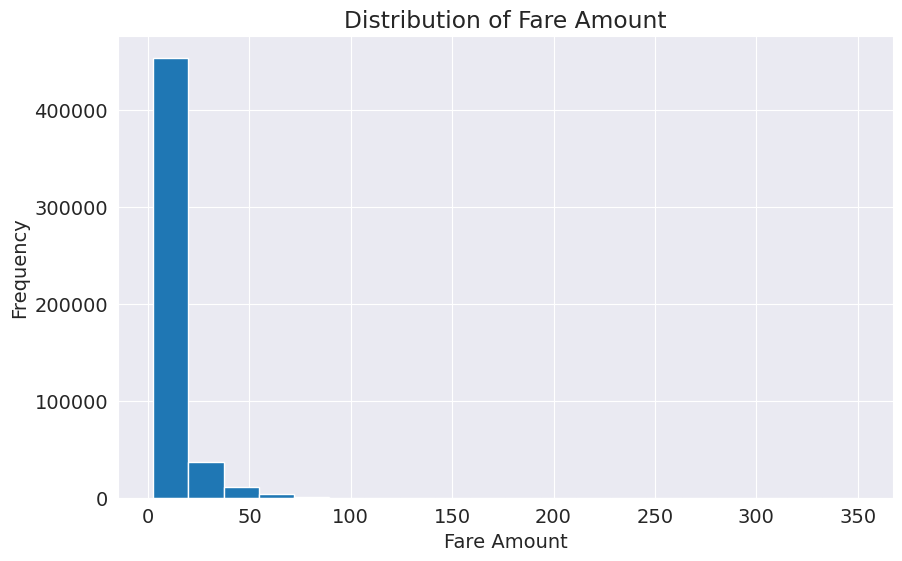

In [21]:
plt.hist(train['fare_amount'], bins=20)
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount')
plt.show()

In [22]:
sampled_data = train.sample(n=10000)  # Adjust the sample size as needed
sampled_data

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,year,month,day,day_of_week,week_of_year,hour,jfk_drop_distance,jfk_pickup_distance,lga_drop_distance,lga_pickup_distance,ewr_drop_distance,ewr_pickup_distance,met_drop_distance,met_pickup_distance,wtc_drop_distance,wtc_pickup_distance
210796,17151591,2012-03-23 02:47:13.0000001,28.1,2012-03-22 22:47:13,-73.976433,40.743950,-73.866905,40.855271,2.0,15.424793,2012,3,22,3,12,22,24.925222,20.233227,8.729413,9.367106,31.771679,17.746063,11.690716,4.093610,19.902961,4.481126
367443,32286390,2015-05-26 11:45:19.0000001,10.0,2015-05-26 07:45:19,-73.957779,40.782246,-73.969643,40.763496,1.0,2.310494,2015,5,26,1,22,7,21.089930,21.780626,8.185873,7.074769,19.111382,20.957861,1.848547,0.555353,6.593821,8.896928
129680,52135157,2009-08-27 16:27:00.00000019,7.7,2009-08-27 12:27:00,-73.990967,40.749844,-74.003242,40.724252,1.0,3.025906,2009,8,27,3,35,12,21.093531,21.613836,12.353237,10.293647,14.934725,16.849636,6.994062,4.030747,1.411091,4.435319
443556,3202054,2009-08-01 17:38:09.0000002,8.1,2009-08-01 13:38:09,-73.993629,40.752342,-73.998802,40.730642,1.0,2.450259,2009,8,1,5,31,13,21.081816,21.954853,11.695911,10.432114,15.490142,16.757490,6.191707,3.949626,2.212124,4.623892
380649,25968818,2013-05-18 17:21:08.0000002,7.0,2013-05-18 13:21:08,-73.975082,40.765125,-73.958282,40.765404,1.0,1.414509,2013,5,18,5,20,13,20.508443,21.557283,7.206749,8.606729,20.067569,18.779156,1.609576,1.874989,7.302333,6.531711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9119,54012173,2013-11-06 09:26:51.0000003,7.0,2013-11-06 05:26:51,-73.952477,40.772694,-73.960243,40.775449,1.0,0.722175,2013,11,6,2,45,5,21.392839,20.711599,7.259407,6.620169,20.413958,20.857559,0.504684,1.170605,8.139722,8.244717
411391,47587185,2013-03-02 15:54:32.0000001,7.5,2013-03-02 11:54:32,-74.001801,40.737568,-74.001373,40.722361,1.0,1.690164,2013,3,2,5,9,11,20.860433,21.673552,12.316870,11.611581,15.034855,15.496429,7.106317,5.671340,1.301088,2.857183
351509,28106634,2009-11-18 18:40:50.0000005,9.3,2009-11-18 14:40:50,-73.962166,40.767532,-73.966446,40.792431,1.0,2.790371,2009,11,18,2,47,14,23.102362,20.909658,7.967680,7.492238,20.921027,19.872833,1.473576,1.321663,9.595810,7.308684
514362,33851961,2009-02-17 19:01:00.000000120,10.1,2009-02-17 15:01:00,-74.008347,40.711563,-74.002464,40.744775,2.0,3.723973,2009,2,17,1,8,15,22.126643,20.916479,11.386832,13.440466,15.738299,14.211384,5.071924,8.442227,3.629902,0.174690


<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

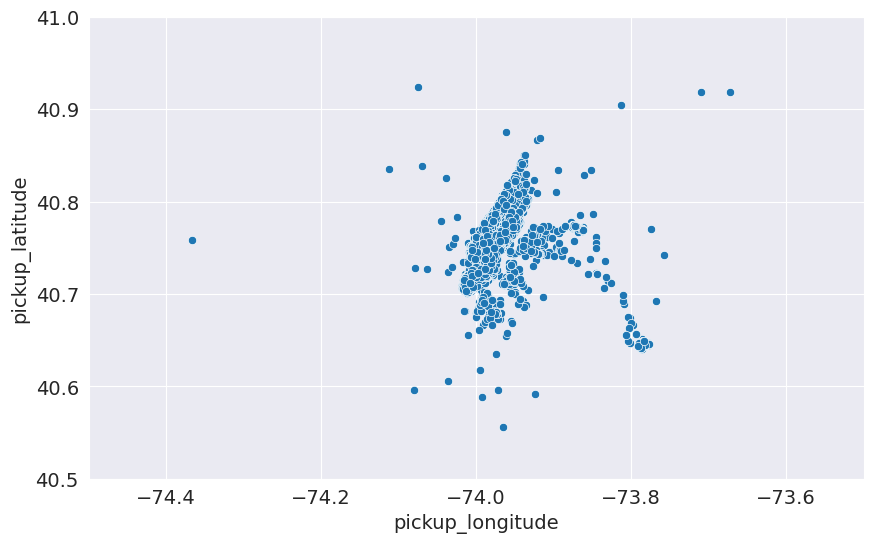

In [23]:
plt.xlim(-74.5, -73.5)
plt.ylim(40.5, 41)
sns.scatterplot(data=sampled_data, x='pickup_longitude', y='pickup_latitude')
#train.shape


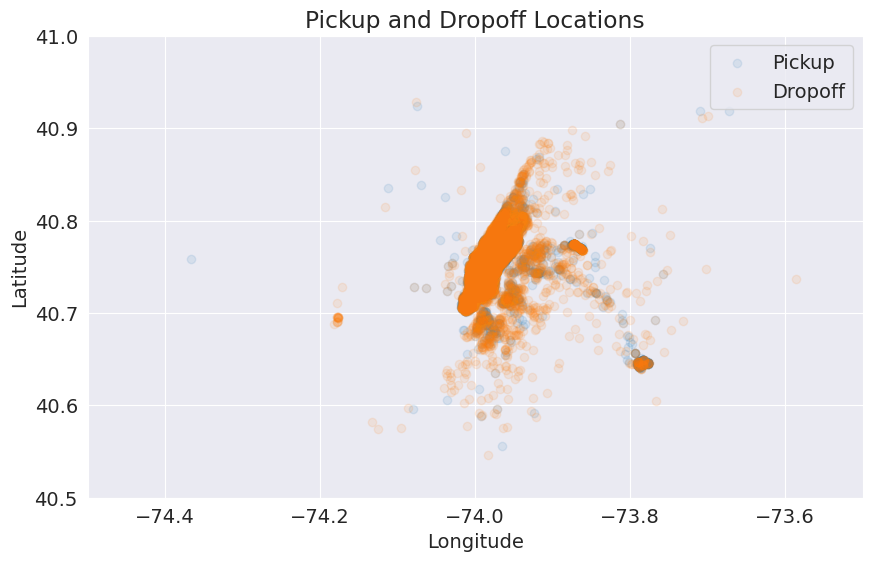

In [24]:
plt.scatter(sampled_data['pickup_longitude'], sampled_data['pickup_latitude'], label='Pickup', alpha=0.1)
plt.scatter(sampled_data['dropoff_longitude'], sampled_data['dropoff_latitude'], label='Dropoff', alpha=0.1)
plt.xlim(-74.5, -73.5)
plt.ylim(40.5, 41)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup and Dropoff Locations')
plt.legend()
plt.show()

In [25]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')

In [26]:
train.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'trip_distance', 'year', 'month',
       'day', 'day_of_week', 'week_of_year', 'hour', 'jfk_drop_distance',
       'jfk_pickup_distance', 'lga_drop_distance', 'lga_pickup_distance',
       'ewr_drop_distance', 'ewr_pickup_distance', 'met_drop_distance',
       'met_pickup_distance', 'wtc_drop_distance', 'wtc_pickup_distance'],
      dtype='object')

In [27]:
#input_cols = ['pickup_longitude',
#       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
#       'passenger_count', 'trip_distance', 'year', 'month', 'day',
#       'day_of_week', 'week_of_year', 'hour']

input_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_distance', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'hour', 'jfk_drop_distance', 'jfk_pickup_distance',
       'lga_drop_distance', 'lga_pickup_distance','ewr_drop_distance', 'ewr_pickup_distance',
       'met_drop_distance', 'met_pickup_distance','wtc_pickup_distance']

target_col = 'fare_amount'

In [28]:
#from sklearn.preprocessing import MinMaxScaler

#mms = MinMaxScaler()
#mms.fit(train[input_cols])
#train[input_cols] = mms.transform(train[input_cols])


In [29]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

In [30]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]
test_inputs = test[input_cols]

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [31]:
def rmse(model):
    model.fit(train_inputs, train_targets)
    train_preds=model.predict(train_inputs)
    val_preds=model.predict(val_inputs)
    train_rmse = np.sqrt(mean_squared_error(train_targets, train_preds, squared=False))
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds, squared=False))
    return train_rmse,val_rmse

In [ ]:

linear_regression = LinearRegression()

rmse(linear_regression)
#(2.8297715840967252, 2.8388940973723478)
#(2.7878406873996013, 2.798409362842983) <-- 乗車値 -- JFK をついか
#(2.2574394956790464, 2.246485925104568) <-- remove メソッド適用


(2.2574394956790464, 2.246485925104568)

In [ ]:
from sklearn.linear_model import Ridge
ridge_regression = Ridge(random_state=42)

rmse(ridge_regression)

(2.257439712090411, 2.2464853567529808)

In [34]:
from xgboost import XGBRegressor
gradient_boosting = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror',tree_method = 'gpu_hist')

rmse(gradient_boosting)
#(1.902768, 2.0520124)
#(1.9019428, 2.049085)
#(1.9020696, 2.0499172) <-- 正規化
#(1.9817282, 2.047697)  <-- fare > 3.1
#(1.9860868, 2.0486085) <-- omitted WTC, MET
#(1.9783899, 2.0442867) <-- 乗車値 -- JFK をついか
#(1.8555322, 1.9205947) <-- remove メソッド適用
#(1.7468156, 1.965096)  <-- 上記を最実施

(1.7468156, 1.965096)

In [35]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv('./sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return 0

In [36]:
predict_and_submit(gradient_boosting,'submission_mane_x7.csv')

0